In [347]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
mice = [25,27,30,36,39,52]
test_sessions = [1,15]
planes = range(1,9)
save_dir = Path(r'C:\Users\shires\Dropbox\Works\Projects\2020 Neural stretching in S1\Analysis\cellpose_mask_test')
base_dir_1 = Path('F:/')
base_dir_2 = Path('D:/')

In [399]:
def draw_contours(ax, mask, img=None, colors='r', linewidths=1, alpha=1, label=None):
    if img is None:
        img = np.zeros(mask.shape)
    
    ax.imshow(img, cmap='gray')
    mask_inds = np.setdiff1d(np.unique(mask), 0)
    for i in mask_inds:
        temp_mask = mask == i
        ax.contour(temp_mask, colors=colors, linewidths=linewidths, alpha=alpha, label=label)

# Differentiate between bigger vs merged ROIs.
- Using I over U
- Needs a threshold - look at individual examples and histogram

In [213]:
mouse = 25
session = 1
plane = 8

base_dir = base_dir_1 if mouse < 31 else base_dir_2
mask_fn = save_dir / f'masks_{mouse:03d}_{session:03d}_{plane:03d}.npy'
ops = np.load(f'{base_dir}{mouse:03}/plane_{plane}/{session:03d}/plane0/ops.npy', allow_pickle=True).item()
mean_mask_list, meanE_mask_list, max_mask_list  = np.load(mask_fn, allow_pickle=True)

Text(0.5, 1.0, 'IoU vs the first mask')

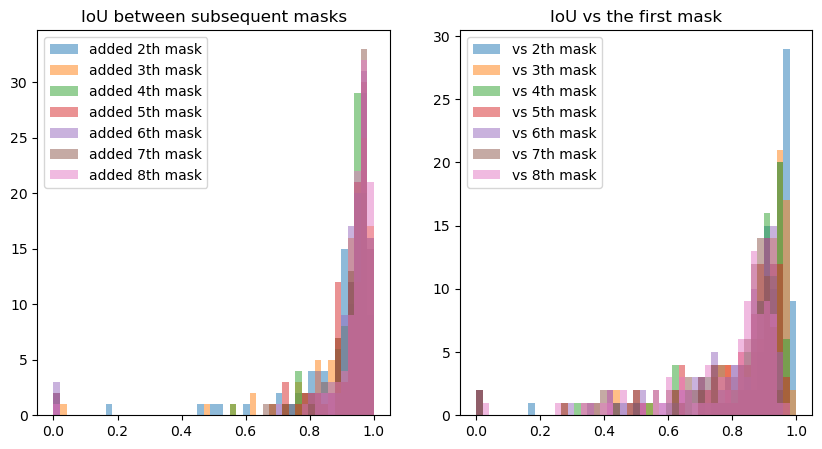

In [214]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
bins = np.linspace(0, 1, 50)

img_i = 1   # 0, 1, 2

if img_i == 0:
    mask_list = mean_mask_list
    img = ops['meanImg']
elif img_i == 1:
    mask_list = meanE_mask_list
    img = ops['meanImgE']
else:
    mask_list = max_mask_list
    img = ops['max_proj']
num_list = len(mask_list)
first_mask = mask_list[0]
first_mask_inds = np.setdiff1d(np.unique(first_mask), 0)
for i in range(num_list-1):
    curr_mask = mask_list[i]
    curr_mask_inds = np.setdiff1d(np.unique(curr_mask), 0)
    next_mask = mask_list[i+1]
    next_mask_inds = np.setdiff1d(np.unique(next_mask), 0)
    temp_iou_mat_sub = np.zeros((len(curr_mask_inds), len(next_mask_inds)))
    temp_iou_mat_first = np.zeros((len(first_mask_inds), len(next_mask_inds)))
    for j in next_mask_inds:
        # find the overlap with the previous mask
        overlap_mask_ind = np.setdiff1d(np.unique(curr_mask[next_mask==j]), 0)
        if len(overlap_mask_ind) > 0:
            for k in overlap_mask_ind:
                y_ind = np.where(curr_mask_inds==k)[0]
                x_ind = np.where(next_mask_inds==j)[0]
                temp_iou_mat_sub[y_ind, x_ind] = \
                    np.sum((curr_mask==k) & (next_mask==j)) / np.sum((curr_mask==k) | (next_mask==j))
        # find the overlap with the first mask
        overlap_mask_ind = np.setdiff1d(np.unique(first_mask[next_mask==j]), 0)
        if len(overlap_mask_ind) > 0:
            for k in overlap_mask_ind:
                y_ind = np.where(first_mask_inds==k)[0]
                x_ind = np.where(next_mask_inds==j)[0]
                temp_iou_mat_first[y_ind, x_ind] = \
                    np.sum((first_mask==k) & (next_mask==j)) / np.sum((first_mask==k) | (next_mask==j))
    ax[0].hist(temp_iou_mat_sub[temp_iou_mat_sub>0].flatten(), bins=bins, label=f'added {i+2}th mask', alpha=0.5);
    ax[1].hist(temp_iou_mat_first[temp_iou_mat_first>0].flatten(), bins=bins, label=f'vs {i+2}th mask', alpha=0.5);
    
ax[0].legend()
ax[0].set_title('IoU between subsequent masks')
ax[1].legend()
ax[1].set_title('IoU vs the first mask')



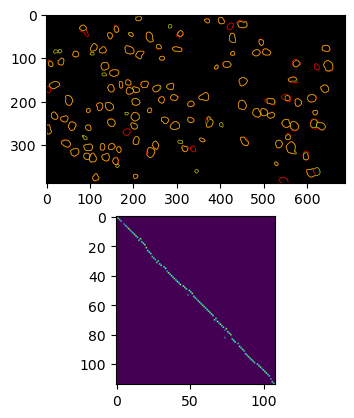

In [229]:
check_with_prev = False

check_num = 3
check_mask = mask_list[check_num-1]
if check_with_prev:
# checking the IoU between subsequent masks
    comp_mask = mask_list[check_num-2]
else:
# checking the IoU vs the first mask
    comp_mask = mask_list[0]

check_mask_inds = np.setdiff1d(np.unique(check_mask),0)
comp_mask_inds = np.setdiff1d(np.unique(comp_mask),0)

max_check_mask_ind = np.max(check_mask)
max_comp_mask_ind = np.max(comp_mask)
iou_mat = np.zeros((len(comp_mask_inds), len(check_mask_inds)))

for j in check_mask_inds:
    # find the overlap with the previous mask
    overlap_mask_ind = np.setdiff1d(np.unique(comp_mask[check_mask==j]), 0)
    if len(overlap_mask_ind) > 0:
        for k in overlap_mask_ind:
            iou_mat[np.where(comp_mask_inds==k)[0], np.where(check_mask_inds==j)[0]] = \
                np.sum((comp_mask==k) & (check_mask==j)) / np.sum((comp_mask==k) | (check_mask==j))

fig, ax = plt.subplots(2,1)
blank_img = np.zeros(check_mask.shape)
draw_contours(ax[0], check_mask, blank_img, colors='r', linewidths=0.5)
draw_contours(ax[0], comp_mask, blank_img, colors='y', linewidths=0.5)
# ax[1].hist(iou_mat[iou_mat>0].flatten(), bins=100);
ax[1].imshow(iou_mat)

In [230]:
lower_bound = 0.2
upper_bound = 0.65
len(np.where((iou_mat > lower_bound) & (iou_mat < upper_bound))[0])

6

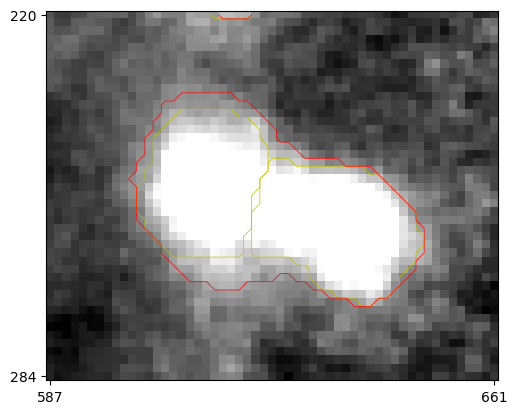

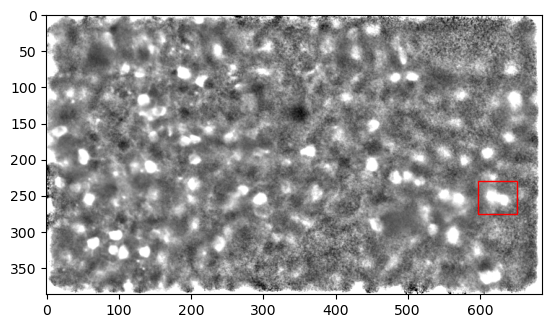

In [243]:
oii = 4
overlap_inds = (np.where((iou_mat > lower_bound) & (iou_mat < upper_bound))[0][oii], 
                np.where((iou_mat > lower_bound) & (iou_mat < upper_bound))[1][oii])
comp_ind = comp_mask_inds[overlap_inds[0]]
check_ind = check_mask_inds[overlap_inds[1]]

comp_mask_box = np.where(comp_mask==comp_ind)
check_mask_box = np.where(check_mask==check_ind)
bounding_box_buffer = 10
bounding_box_ymin = min(np.min(comp_mask_box[0]), np.min(check_mask_box[0]))
bounding_box_ymin = max(0, bounding_box_ymin - bounding_box_buffer)
bounding_box_ymax = max(np.max(comp_mask_box[0]), np.max(check_mask_box[0]))
bounding_box_ymax = min(img.shape[0], bounding_box_ymax + bounding_box_buffer)
bounding_box_xmin = min(np.min(comp_mask_box[1]), np.min(check_mask_box[1]))
bounding_box_xmin = max(0, bounding_box_xmin - bounding_box_buffer)
bounding_box_xmax = max(np.max(comp_mask_box[1]), np.max(check_mask_box[1]))
bounding_box_xmax = min(img.shape[1], bounding_box_xmax + bounding_box_buffer)

temp_overlap_img = img[bounding_box_ymin : bounding_box_ymax,
                          bounding_box_xmin : bounding_box_xmax]
temp_overlap_comp_mask = comp_mask[bounding_box_ymin : bounding_box_ymax,
                            bounding_box_xmin : bounding_box_xmax]
temp_overlap_check_mask = check_mask[bounding_box_ymin : bounding_box_ymax,
                                bounding_box_xmin : bounding_box_xmax]
fig, ax = plt.subplots()
ax.imshow(temp_overlap_img, cmap='gray')
ax.set_yticks([0, temp_overlap_img.shape[0]-1])
ax.set_xticks([0, temp_overlap_img.shape[1]-1])
ax.set_yticklabels([bounding_box_ymin-bounding_box_buffer, bounding_box_ymax+bounding_box_buffer-1])
ax.set_xticklabels([bounding_box_xmin-bounding_box_buffer, bounding_box_xmax+bounding_box_buffer-1])
draw_contours(ax, temp_overlap_comp_mask, img = temp_overlap_img, colors='y', linewidths=0.5)
draw_contours(ax, temp_overlap_check_mask, img = temp_overlap_img, colors='r', linewidths=0.5)
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
from matplotlib import patches
box_rect = patches.Rectangle((bounding_box_xmin, bounding_box_ymin),
                                bounding_box_xmax-bounding_box_xmin,
                                bounding_box_ymax-bounding_box_ymin,
                                linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(box_rect)


In [244]:
# Calculate percentile of the smaller ROI over all ROI size
size_dist = [np.sum(comp_mask==i) for i in comp_mask_inds]
select_roi_size = np.sum(comp_mask==comp_ind)
percentile = np.sum(np.array(size_dist)<select_roi_size)/len(size_dist)
print('Percentile of the smaller ROI over all ROI size: ', percentile)

Percentile of the smaller ROI over all ROI size:  0.8157894736842105


In [245]:
size_dist = [np.sum(check_mask==i) for i in check_mask_inds]
select_roi_size = np.sum(check_mask==check_ind)
percentile = np.sum(np.array(size_dist)<select_roi_size)/len(size_dist)
print('Percentile of the smaller ROI over all ROI size: ', percentile)

Percentile of the smaller ROI over all ROI size:  0.9907407407407407


# ROI collection protocol:
- Compute IoU.
    - If there are multiple overlapping ROIs:
        - Collect all ROIs that are overlapping (assert up to 3). Calculate IoA of multiple ROIs (All intersection / all multiple ROIs, and all intersection / one large ROI)
            - If either IOA > threshold (0.7?), disregard the big one.
            - If not, then look at individual IoA and follow the procedure below (in case of one-to-one overlapping)
        - Repeat in the other way (check if there are multiple ROIs from the bigger diameter that overlap with one ROI from the smaller diameter)
    - Else:
        - If IoU <= 0.3:
            - If either IoA > threshold (0.5?), merge.
            - If both IoA < threshold (0.5?), leave both.
        - Elif IoU >= 0.7, merge
        - Else (if 0.3 < IoU < 0.7), calculate area percentile and take the one with percentile closer to 0.5
            - Don’t take the setdiff part – it can be picked up by another image type, or it can be just lost.


## Determine the threshold for multiple ROI situation

In [341]:
def get_overlap_mat_list(mask):
    overlap_mat_list = []
    for i in range(mask.shape[0]-1):
        curr_roi_inds = np.setdiff1d(np.unique(mask[i, :, :]), [0])
        next_roi_inds = np.setdiff1d(np.unique(mask[i+1, :, :]), [0])
        temp_overlap_mat = np.zeros((len(curr_roi_inds), len(next_roi_inds)))
        for j in range(len(curr_roi_inds)):
            for k in range(len(next_roi_inds)):
                intersection_map = (mask[i, :, :] == curr_roi_inds[j]) * (mask[i+1, :, :] == next_roi_inds[k]) > 0
                union_map = (mask[i, :, :] == curr_roi_inds[j]) + (mask[i+1, :, :] == next_roi_inds[k]) > 0
                temp_overlap_mat[j, k] = np.sum(intersection_map) / np.sum(union_map)
        overlap_mat_list.append(temp_overlap_mat)
    return overlap_mat_list

In [367]:
iou_threshold = 0.3
image_type_list = ['mean', 'meanE', 'max']
overlap_df = pd.DataFrame(columns=['mouse', 'session', 'plane', 'image_type', 'curr_multi_ind', 'next_multi_ind'])
for mouse in mice:
    for session in test_sessions:
        for plane in planes:
            print(f'mouse {mouse}, session {session}, plane {plane}')
            results = np.load(save_dir / f'masks_{mouse:03d}_{session:03d}_{plane:03d}.npy', allow_pickle=True)
            for mask_ind, mask in enumerate(results):
                overlap_mat_list = get_overlap_mat_list(mask)
                for overlap_ind, overlap_mat in enumerate(overlap_mat_list):
                    multi_ind_next = np.where(np.sum(overlap_mat > iou_threshold, axis=0)>1)[0]
                    multi_ind_curr = np.where(np.sum(overlap_mat > iou_threshold, axis=1)>1)[0]
                    if (len(multi_ind_next) > 0) or (len(multi_ind_curr) > 0):
                        next_roi_inds = np.setdiff1d(np.unique(mask[overlap_ind+1, :, :]), [0])
                        next_multi_inds = next_roi_inds[multi_ind_next]
                        curr_roi_inds = np.setdiff1d(np.unique(mask[overlap_ind, :, :]), [0])
                        curr_multi_inds = curr_roi_inds[multi_ind_curr]
                        image_type = image_type_list[mask_ind]
                        temp_df = pd.DataFrame({'mouse': mouse,
                                                'session': session,
                                                'plane': plane,
                                                'image_type': image_type,
                                                'curr_multi_ind': [curr_multi_inds],
                                                'next_multi_ind': [next_multi_inds]})
                        overlap_df = pd.concat([overlap_df, temp_df], ignore_index=True)


mouse 25, session 1, plane 1
mouse 25, session 1, plane 2
mouse 25, session 1, plane 3
mouse 25, session 1, plane 4
mouse 25, session 1, plane 5
mouse 25, session 1, plane 6
mouse 25, session 1, plane 7
mouse 25, session 1, plane 8
mouse 25, session 15, plane 1
mouse 25, session 15, plane 2
mouse 25, session 15, plane 3
mouse 25, session 15, plane 4
mouse 25, session 15, plane 5
mouse 25, session 15, plane 6
mouse 25, session 15, plane 7
mouse 25, session 15, plane 8
mouse 27, session 1, plane 1
mouse 27, session 1, plane 2
mouse 27, session 1, plane 3
mouse 27, session 1, plane 4
mouse 27, session 1, plane 5
mouse 27, session 1, plane 6
mouse 27, session 1, plane 7
mouse 27, session 1, plane 8
mouse 27, session 15, plane 1
mouse 27, session 15, plane 2
mouse 27, session 15, plane 3
mouse 27, session 15, plane 4
mouse 27, session 15, plane 5
mouse 27, session 15, plane 6
mouse 27, session 15, plane 7
mouse 27, session 15, plane 8
mouse 30, session 1, plane 1
mouse 30, session 1, plane 

In [371]:
# save the df
overlap_df.to_csv(save_dir/'overlap_df.csv', index=False)

In [413]:
def draw_mask_overlaps(ax, mask_curr, mask_next, roi_ind_curr, roi_ind_next, buffer=10):
    img_dims = mask_curr.shape
    assert img_dims == mask_next.shape
    yrange = [img_dims[0], 0]
    xrange = [img_dims[1], 0]

    if type(roi_ind_curr) == int:
        roi_ind_curr = [roi_ind_curr]
    if type(roi_ind_next) == int:
        roi_ind_next = [roi_ind_next]

    temp_curr_mask = np.zeros(img_dims, dtype=bool)
    for i in roi_ind_curr:
        draw_curr_mask = np.zeros(img_dims, dtype=bool)
        temp_curr_mask[mask_curr == i] = True
        draw_curr_mask[mask_curr == i] = True
        draw_contours(ax, draw_curr_mask, colors='m', linewidths=1, label='curr')
        temp_inds = np.where(mask_curr == i)
        yrange[0] = min(np.min(temp_inds[0]), yrange[0])
        yrange[1] = max(np.max(temp_inds[0]), yrange[1])
        xrange[0] = min(np.min(temp_inds[1]), xrange[0])
        xrange[1] = max(np.max(temp_inds[1]), xrange[1])
    temp_next_mask = np.zeros(img_dims, dtype=bool)
    for i in roi_ind_next:
        draw_next_mask = np.zeros(img_dims, dtype=bool)
        temp_next_mask[mask_next == i] = True
        draw_next_mask[mask_next == i] = True
        draw_contours(ax, draw_next_mask, colors='c', linewidths=1, label='next')
        temp_inds = np.where(mask_next == i)
        yrange[0] = min(np.min(temp_inds[0]), yrange[0])
        yrange[1] = max(np.max(temp_inds[0]), yrange[1])
        xrange[0] = min(np.min(temp_inds[1]), xrange[0])
        xrange[1] = max(np.max(temp_inds[1]), xrange[1])
    
    yrange[0] = max(yrange[0] - buffer, 0)
    yrange[1] = min(yrange[1] + buffer, data.shape[1])
    xrange[0] = max(xrange[0] - buffer, 0)
    xrange[1] = min(xrange[1] + buffer, data.shape[2])
    ax.set_xlim(xrange)
    ax.set_ylim(yrange)

    intersection = np.logical_and(temp_curr_mask, temp_next_mask)
    ioa_curr = intersection.sum() / temp_curr_mask.sum()
    ioa_next = intersection.sum() / temp_next_mask.sum()

    curr_size_dist = [np.sum(mask_curr==i) for i in np.setdiff1d(np.unique(mask_curr), [0])]
    next_size_dist = [np.sum(mask_next==i) for i in np.setdiff1d(np.unique(mask_next), [0])]
    curr_size_percentile = []
    for i in roi_ind_curr:
        select_roi_size = np.sum(mask_curr==i)
        percentile = f'{np.sum(np.array(curr_size_dist)<select_roi_size)/len(curr_size_dist):.2f}'
        curr_size_percentile.append(float(percentile))
    next_size_percentile = []
    for i in roi_ind_next:
        select_roi_size = np.sum(mask_next==i)
        percentile = f'{np.sum(np.array(next_size_dist)<select_roi_size)/len(next_size_dist):.2f}'
        next_size_percentile.append(float(percentile))

    ax.set_title(f'IOA curr: {ioa_curr:.2f}, IOA next: {ioa_next:.2f}\n\
                  curr size percentile: {curr_size_percentile}\n\
                  next size percentile: {next_size_percentile}')

In [423]:
i = 100
mouse = overlap_df.iloc[i]['mouse']
session  = overlap_df.iloc[i]['session']
plane = overlap_df.iloc[i]['plane']
image_type = overlap_df.iloc[i]['image_type']
results = np.load(save_dir / f'masks_{mouse:03d}_{session:03d}_{plane:03d}.npy', allow_pickle=True)

if mouse < 31:
    base_dir = base_dir_1
else:
    base_dir = base_dir_2
# ops_fn = base_dir / f'{mouse:03}' / f'plane_{plane}' / f'{session:03}' / 'plane0' / 'ops.npy'
# ops = np.load(ops_fn, allow_pickle=True).item()
if image_type == 'mean':
    mask = results[0]
    img = ops['meanImg']
elif image_type == 'meanE':
    mask = results[1]
    img = ops['meanImgE']
else:
    mask = results[2]
    img = ops['max_proj']

overlap_mat_list = get_overlap_mat_list(mask)
for overlap_ind, overlap_mat in enumerate(overlap_mat_list):
    multi_ind_next = np.where(np.sum(overlap_mat > iou_threshold, axis=0)>1)[0]
    multi_ind_curr = np.where(np.sum(overlap_mat > iou_threshold, axis=1)>1)[0]
    if (len(multi_ind_next) > 0) or (len(multi_ind_curr) > 0):
        next_roi_inds = np.setdiff1d(np.unique(mask[overlap_ind+1, :, :]), [0])
        next_multi_inds = next_roi_inds[multi_ind_next]
        overlap_curr_roi_inds = []
        overlap_next_roi_inds = []
        for ind in multi_ind_next:
            temp_overlap_curr_roi_inds = np.where(overlap_mat[:, ind] > iou_threshold)[0]
            overlap_curr_roi_inds.append(temp_overlap_curr_roi_inds)
            temp_multi_overlap_next_roi_inds = []
            for curr_ind in temp_overlap_curr_roi_inds:
                temp_overlap_next_roi_inds = np.where(overlap_mat[curr_ind, :] > iou_threshold)[0]
                temp_multi_overlap_next_roi_inds.append(temp_overlap_next_roi_inds)
            overlap_next_roi_inds.append(np.unique(temp_multi_overlap_next_roi_inds))

        for ind in multi_ind_curr:
            temp_overlap_next_roi_inds = np.where(overlap_mat[ind, :] > iou_threshold)[0]
            overlap_next_roi_inds.append(temp_overlap_next_roi_inds)
            temp_multi_overlap_curr_roi_inds = []
            for next_ind in temp_overlap_next_roi_inds:
                temp_overlap_curr_roi_inds = np.where(overlap_mat[:, next_ind] > iou_threshold)[0]
                temp_multi_overlap_curr_roi_inds.append(temp_overlap_curr_roi_inds)
            overlap_curr_roi_inds.append(np.unique(temp_multi_overlap_curr_roi_inds))

        print(f'Overlap between {overlap_ind} and {overlap_ind+1}')
        print(f'Next: {overlap_next_roi_inds}')
        print(f'Current: {overlap_curr_roi_inds}')


Overlap between 0 and 1
Next: [array([154], dtype=int64)]
Current: [array([142, 144], dtype=int64)]
Overlap between 1 and 2
Next: [array([93], dtype=int64), array([94], dtype=int64), array([133], dtype=int64), array([141], dtype=int64), array([155], dtype=int64)]
Current: [array([87, 93], dtype=int64), array([88, 92], dtype=int64), array([132, 136], dtype=int64), array([141, 145], dtype=int64), array([157, 158], dtype=int64)]


C:\Users\shires\AppData\Local\Temp\ipykernel_13468\2789333490.py:9: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(temp_mask, colors=colors, linewidths=linewidths, alpha=alpha, label=label)


(382.0, 339.0)

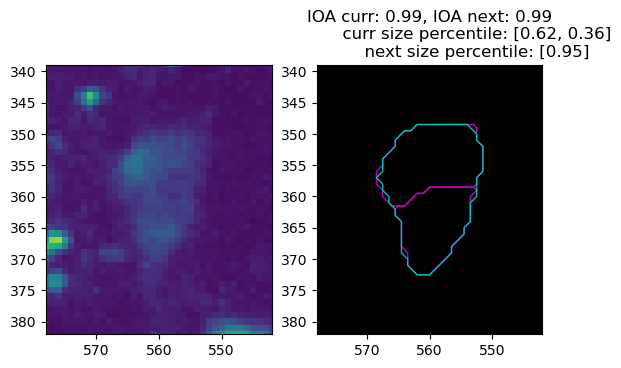

In [417]:
overlap_threshold = 0.3
mat_ind = 1
overlap_ind = 1
curr_mask = mask[mat_ind]
next_mask = mask[mat_ind+1]
# curr_roi_inds = np.setdiff1d(np.unique(curr_mask), [0])
# next_roi_inds = np.setdiff1d(np.unique(next_mask), [0])

# roi_ind_next = 300
# ind_next = np.where(next_roi_inds == roi_ind_next)[0]
ind_next = 
overlap_mat = overlap_mat_list[mat_ind]
ind_curr = np.where(overlap_mat[:, ind_next] > overlap_threshold)[0]
roi_ind_curr = curr_roi_inds[ind_curr]
fig, ax = plt.subplots(1,2)
ax[0].imshow(img)
draw_mask_overlaps(ax[1], curr_mask, next_mask, roi_ind_curr, roi_ind_next)
ax[1].set_xlim(np.roll(ax[1].get_xlim(), 1))
ax[1].set_ylim(np.roll(ax[1].get_ylim(), 1))
ax[0].set_xlim(ax[1].get_xlim())
ax[0].set_ylim(ax[1].get_ylim())



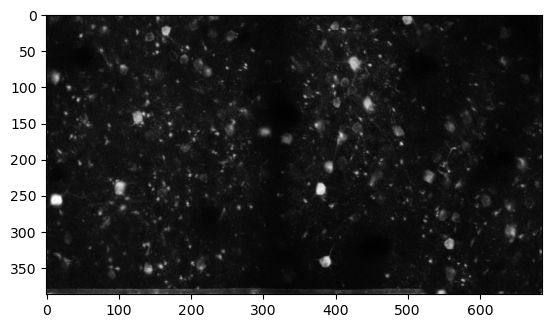

In [415]:
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')

# Run it again in the next notebook
- 230815_overlap_df_again.ipynb

## Determine the threshold for IoU <= 0.3

In [38]:
j = 3
comp_mask[check_mask==j]

array([], dtype=uint16)

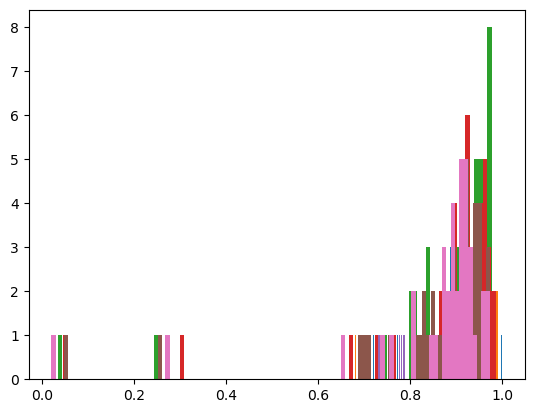

In [18]:
fig, ax = plt.subplots()
mask_list = mean_mask_list
num_list = len(mask_list)
first_mask = mask_list[0]
for i in range(num_list-1):
    curr_mask = mask_list[0]
    max_curr_mask_ind = np.max(curr_mask)
    next_mask = mask_list[i+1]
    max_next_mask_ind = np.max(next_mask)
    temp_iou_mat = np.zeros((max_curr_mask_ind, max_next_mask_ind))
    for j in range(1, max_next_mask_ind+1):
        # find the overlap with the previous mask
        overlap_mask_ind = np.setdiff1d(np.unique(curr_mask[next_mask==j]), 0)
        if len(overlap_mask_ind) > 0:
            for k in overlap_mask_ind:
                temp_iou_mat[k-1, j-1] = np.sum((curr_mask==k) & (next_mask==j)) / np.sum((curr_mask==k) | (next_mask==j))

    ax.hist(temp_iou_mat[temp_iou_mat>0].flatten(), bins=100);


In [12]:
np.max(mask_list[0])

62

In [9]:
len(mean_mask_list)

8